In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
from lmfit import Model,Parameter,Parameters
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import os
from functions import plot_preprocessed_dist,plot_track_characteristics,mmsd_plot,cutoff_function,msd,data_pool,two_distributions_plot,partition
%matplotlib inline
%reload_ext autoreload

# From TrackMate to diffusion coefficients

The following code allows the user to use a set of TrackMate generated *csv* tracks to compute the MSD curve and diffusion coefficient associated to each track. The experimental time step `dt` between each frame must be set by the user. I use `Pandas` to turn the csv files into a `DataFrame`. I then perform a loop over the track IDs to recover the positions of the constitutive spots and compute a mean square displacement for each track.

### Filter on the number of frames

The user may want to filter out tracks that are very short, i.e. these tracks may result from the tracking of background noise. The minimum number of frames is generally set to 5 or more. One may also want to get rid of very long tracks, which may represent the tracking of dust in the original movie. 

### Computation of the MSD curves

Once the coordinates of each spot that constitutes a trajectory are known, we can compute the MSD for each chosen timelag $n \Delta \tau$ : 

$$ \rho_n = \frac{1}{N - n} \sum_{i=0}^{N-n-1}\left[(x_{n+i} - x_i)^2 + (y_{n+i} - y_i)^2\right] \qquad n=1,...,N-1 $$

For a given trajectory, we can compute $N-1$ such $\rho_n$, which we will store in an array called `rhon`. This is the MSD curve associated to a given track. For free diffusion, $\rho$ is expected to be linear in $n \Delta \tau$. In practise, $\rho$ will be modelled with a function in power $\alpha$: $\rho(n\Delta \tau) = 4 D (n\Delta \tau)^\alpha$. I use the package `lmfit` to perform the fit. Each fit parameter $D$ and $\alpha$ can be bounded. 

The fit of a MSD curve should not be performed over all tracks, as the accuracy of the MSD decreases as the timelag increases. In the same way, localization uncertainty is large for small timelags. I will perform the fits over 30 % of the data points. Later on, once the free diffusion tracks are identified, I will perform the fit using a more optimal approach described by Michalet (2010). We can compute a $R^2$ coefficient of determination and get rid of the tracks for which the fit of the MSD curve has $R^2$ below a user-defined threshold. 

For each track, the value of $\alpha$, $D$, the total number of frames $N$ and the confinement ratio (defined as the end-to-end distance divided by the total displacement) are stored in the `alphaD` matrix. These quantities will be used to perform an unsupervised cluster classification. 


In [2]:
#files = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]
files = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]

#Experimental parameters:

dt = 0.05  #time step

################################################
####### FIRST FILTER ON NUMBER OF FRAMES #######
################################################

minframe = 8
maxframe = 100

################################################
############# CONFIGURE FIT MODEL ##############
################################################

minalpha = 1.0E-03
minD = 1.0E-04
maxD = 4
maxalpha = 3

msd_model = Model(msd)
params = Parameters()
params['alpha']   = Parameter(name='alpha', value=1.0, min=minalpha,max=maxalpha)
params['D']   = Parameter(name='D', value=0.1, min=minD,max=maxD)

################################################
##############   INITIALIZATION   ##############
################################################

frame_alldata = []
alphaD = []
rhoens_alltracks = []
reduced_linear_data = []
INDEX = []
total_tracks=0
anomalous_percentage=0

for filename in files:
    folder_name = filename[5:-4]
    output_folder = "Result/"+folder_name

    data = pd.read_csv(filename) 
    tracklist = data.TRACK_ID.unique()  #list of track ID in data

    for tid in tracklist:

        trackid = data["TRACK_ID"] == tid
        x = data[trackid]["POSITION_X"].to_numpy()   #x associated to track 'tid'
        y = data[trackid]["POSITION_Y"].to_numpy()   #y associated to track 'tid'
        intensity = data[trackid]["MEAN_INTENSITY"].to_numpy()

        frame_alldata.append(len(x))

        rhon = []#list of rho_n for a given track
        if len(x)<maxframe and len(x)>minframe:
            for n in range(1,len(x)):             #for each n = each time lag
                s = 0
                for i in range(0,len(x)-n):
                    s+=(x[n+i] - x[i])**2 + (y[n+i] - y[i])**2
                rhon.append(1/(len(x)-n)*s)

            N = len(rhon)+1
            t = [n*dt for n in np.linspace(1,N-1,N-1)]

            nbrpts = int(0.3*N)
            result = msd_model.fit(rhon[:nbrpts+1], params, t=t[:nbrpts+1])
            
            s=0
            for p in range(0,len(x)-1):
                s+= np.sqrt((x[p+1]-x[p])**2+(y[p+1]-y[p])**2)
            confinement_ratio = np.sqrt((x[-1]-x[0])**2+(y[-1]-y[0])**2)/s
            
            alpha = result.params['alpha'].value
            D = result.params['D'].value
            rsquare = 1 - result.residual.var() / np.var(rhon[:nbrpts+1])

            if rsquare > 0.8 and confinement_ratio!=0.0:
                rhoens_alltracks.append(rhon)
                plot_element = [alpha,D,confinement_ratio,len(x)] #len(x)
                alphaD.append(plot_element)
                INDEX.append([x,y])

            else:
                anomalous_percentage+=1

            total_tracks+=1

print(len(rhoens_alltracks),np.shape(alphaD))
print("Percentage of dismissed MSDs due to bad fit : ",anomalous_percentage/total_tracks*100," %")

alphaD = np.array(alphaD)

2880 (2880, 4)
Percentage of dismissed MSDs due to bad fit :  54.559798043546856  %


### Unsupervised classification

The `alphaD` array contains $\alpha$, $D$, the confinement ratio ($c$) and number of frames associated to each track that survived the filtering process (minimum number of square and minimum $R²$ for the fit). We can try to detect clusters in the $\alpha$, $D$ space. The K-Means algorithm takes the standardized and normalized distributions of $\alpha$, $D$ and $c$ and groups the elements into $k$ clusters, where $k$ is user-defined (here we set it to 3). 

Three histograms show the distributions of the quantities of interest (features). In red, we monitor the standardized and normalized distributions, using respectively functions `PowerTransform(method='box-cox')` and `minmax_scale`. All the features must be strictly positive for `PowerTransform` to work. This function can turn a Poisson distribution into something that resembles a Gaussian. The more the transformed distribution looks like a Gaussian, the better. 

`labels` is an integer array that associates to each track (each feature row) a class (0, 1, 2 here). We can associate a color to each class and plot each MSD with the associated color. 

2880


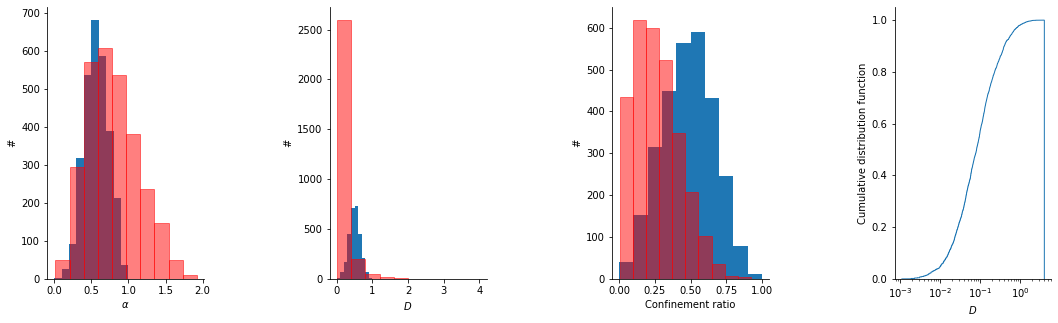

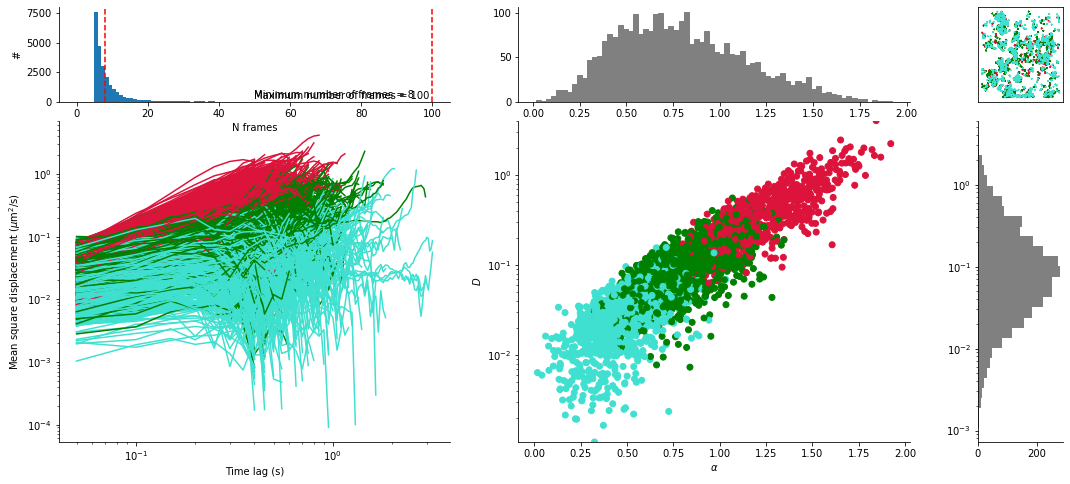

In [3]:
###########################################################
####################COMPUTE K MEAN ########################
###########################################################

from sklearn import cluster, datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import preprocessing

k_means = cluster.KMeans(n_clusters=3)
FEATURES = np.array(alphaD)

pt = preprocessing.PowerTransformer(method='box-cox', standardize=True) #define standardizer
PROCESSED_FEATURES = pt.fit_transform(FEATURES[:,:3]) #standardize (only alpha,D,c)
PROCESSED_FEATURES = preprocessing.minmax_scale(PROCESSED_FEATURES) #normalize

k_means.fit(PROCESSED_FEATURES)
labels = k_means.labels_

print(len(labels))

colors = ['g', "crimson", 'turquoise',"pink",'lightcoral','orange','blue']
color_array = []
for k in range(len(labels)):
    color_index = labels.astype(np.int)[k]
    color_array.append(colors[color_index])

####PLOT PROCESSED DISTRIBUTIONS#########################
plot_preprocessed_dist(PROCESSED_FEATURES,FEATURES)

#########################################################
############## END OF K-MEAN ############################
#########################################################


plot_track_characteristics(dt,FEATURES,rhoens_alltracks,frame_alldata,color_array,minframe,maxframe,INDEX)
alpha,diff,conf,length_track = zip(*FEATURES)

# Other stuff




In [ ]:
traj1,color1 = INDEX,color_array
print(np.shape(traj1))

In [ ]:
traj2,color2 = INDEX,color_array
print(np.shape(traj2))

In [ ]:
for t1 in traj1:
    for t2 in traj2:
        intersect = np.intersect1d(t1[0],t2[0])
        if len(intersect)!=0:
            print(t1[0],'\n',t2[0],"\n Track length difference = ",len(t1[0])-len(t2[0]),'\n')

In [ ]:
import cv2

imagepath = "Data/SM1/"

fig = plt.figure(figsize=(10,10))

image = plt.imread(imagepath+'sm1.jpg')
print(np.shape(image))
plt.imshow(image,cmap='Greys',alpha=0.5)

image_blur = cv2.blur(image,(10,10))

clustercolor = np.unique(color1)
for color in clustercolor:
    for k in range(len(color1)):
        if color1[k]==color:
            x = [xx/0.133 for xx in traj1[k][0]]
            y = [yy/0.133 for yy in traj1[k][1]]
            line = int(y[0])
            column = int(x[0])
            if image_blur[line][column]>1:
                plt.plot(x,y,c='r')
            
#for color in clustercolor:
#    for k in range(len(color2)):
#        if color1[k]==color:            
#            x = [xx/0.133 for xx in traj2[k][0]]
#            y = [yy/0.133 for yy in traj2[k][1]]
#            plt.plot(x,y,c='r')
plt.gca().invert_yaxis()
plt.savefig(imagepath+'tracks_on_image_shortink.png')
plt.show()

plt.imshow(image_blur)
plt.show()

print(image_blur,image)

# Select a cluster to perform linear MSD analysis

In [6]:
clustercolor = input('Over which cluster do you want to perform a linear MSD analysis? Options: g, k, crimson, turquoise, pink, lightcoral...')

linear_data = []

for k in range(len(color_array)):
    if color_array[k]==clustercolor:
        linear_data.append(rhoens_alltracks[k][:])

reduced_linear_data = np.array(linear_data)

with open('filtered_msd.txt','w') as f:
    for listk in reduced_linear_data:
        for n in range(len(listk)):
            f.write(str(listk[n])+' ')
        f.write('\n')

Over which cluster do you want to perform a linear MSD analysis? Options: g, k, crimson, turquoise, pink, lightcoral...g


60
Use all tracks to compute an ensemble MSD and its associated variance...
Plot ensemble MSD...


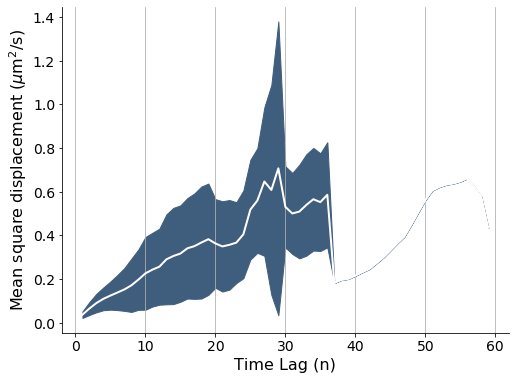

After how many time steps n do you want to cut the data? 20
You have set the cutoff to a time lag of  20  steps...
Initial run to determine the best theoretical values for D and sigma.
It is estimated that the lowest error will be for a number of fitting points P =  18  for which the relative error sigma/b =  0.29727000524468955
D =  0.0976
It is estimated that the lowest error will be when the number of fitting points P =  4  for which the relative error sigmaa/a =  0.033885895752229465
sigma =  0.0591
Second run with accurate values for D and sigma.
D =  0.0976
sigma =  0.0591
Done.


In [7]:
from sklearn.linear_model import LinearRegression
from functions import *
import os


data,N_array = MSD_tracks_from_file("filtered_msd.txt")

N = np.shape(data)[1]+1
print(N)
D= 0.2
sigma=0.3
T = N*dt
epsilon = 4*sigma**2
alpha = 4*D*dt

##############" PLOT ALL DATA MSD #################
print("Use all tracks to compute an ensemble MSD and its associated variance...")
msd,var = average(data)
timelagn = np.linspace(1,N-1,N-1)
timelag = [n*dt for n in timelagn]


print("Plot ensemble MSD...")
mmsd_plot(timelagn,msd,var)

### SELECT CUTOFF #################################

data,timelag,msd,var,cutoff = cutoff_function(dt,N,data,timelag,msd,var)

##### PLOT MSD AND VARIANCE WITH CUTOFF ###############

for z in range(2):
    if z==0:
        print("Initial run to determine the best theoretical values for D and sigma.")
    if z==1:
        print("Second run with accurate values for D and sigma.")
    theory_msd = [4*D*n + epsilon for n in timelag]
    theory_variance = THEORETICAL_VARIANCE_2(N_array,sigma,D,dt)[:cutoff]
    cov = COVARIANCE(data,cutoff)
    theory_covariance = THEORETICAL_COVARIANCE_2(N_array,sigma,D,dt,cutoff)#[:cutoff,:cutoff]

    ###########################################
    ############### ERROR SLOPE ###############
    Pmin_array = [int(p) for p in np.linspace(2,cutoff-2,cutoff-3)]
    sigmab_theory = []
    sigmab_exp_th = []
    sigmab_exp    = []

    for p in Pmin_array:
        sigmab_theory.append(NormMSDSlopeError(N,sigma,D,dt,p))
        sigmab_exp_th.append(NormMSDSlopeError_exp(N,sigma,D,dt,theory_variance,theory_covariance,p))
        sigmab_exp.append(NormMSDSlopeError_exp(N,sigma,D,dt,var,cov,p))

    min_y = min(sigmab_exp) 
    min_x = Pmin_array[sigmab_exp.index(min_y)]

    if z==0:
        print("It is estimated that the lowest error will be for a number of fitting points P = ",min_x," for which the relative error sigma/b = ",min_y)


    timelag = np.array(timelag)
    x = timelag.reshape((-1, 1))
    y = msd
    ctffb = int(min_x)
    model = LinearRegression().fit(x[:ctffb], y[:ctffb])
    r_sq = model.score(x[:ctffb], y[:ctffb])
    fit_b = model.predict(x)

    Dvalue = round(model.coef_[0]/4,4)
    print("D = ",Dvalue)
    Dvalue_error = round(min_y*model.coef_[0]/4,4)


    ###########################################
    ############### ERROR INTERCEPT ###############

    Pmin_array = [int(p) for p in np.linspace(2,cutoff-2,cutoff-3)]
    sigmaa_theory = []
    sigmaa_exp_th = []
    sigmaa_exp    = []
    for p in Pmin_array:
        sigmaa_theory.append(NormMSDInterceptError(N,sigma,D,dt,p))
        sigmaa_exp_th.append(NormMSDInterceptError_exp(N,sigma,D,dt,theory_variance,theory_covariance,p))
        sigmaa_exp.append(NormMSDInterceptError_exp(N,sigma,D,dt,var,cov,p))

    min_y = min(sigmaa_exp) 
    min_x = Pmin_array[sigmaa_exp.index(min_y)]

    if z==0:
        print("It is estimated that the lowest error will be when the number of fitting points P = ",min_x," for which the relative error sigmaa/a = ",min_y)

    timelag = np.array(timelag)
    xa = timelag.reshape((-1, 1))
    ya = msd
    ctffa = int(min_x)
    model = LinearRegression().fit(x[:ctffa], y[:ctffa])
    r_sq = model.score(x[:ctffa], y[:ctffa])
    fit_a = model.predict(x)

    loc_sigma = round(np.sqrt(model.intercept_/4),4)
    loc_sigma_error = round(min_y/2*model.intercept_,4)
    print("sigma = ",loc_sigma)
    
    D = Dvalue
    if np.isnan(loc_sigma)==True:
        print("sigma is nan. Replace with value close to zero.")
        sigma = 0.0000001
    else:
        sigma = loc_sigma

    epsilon = 4*sigma**2
    alpha = 4*D*dt
    if z==1:
        print("Done.")

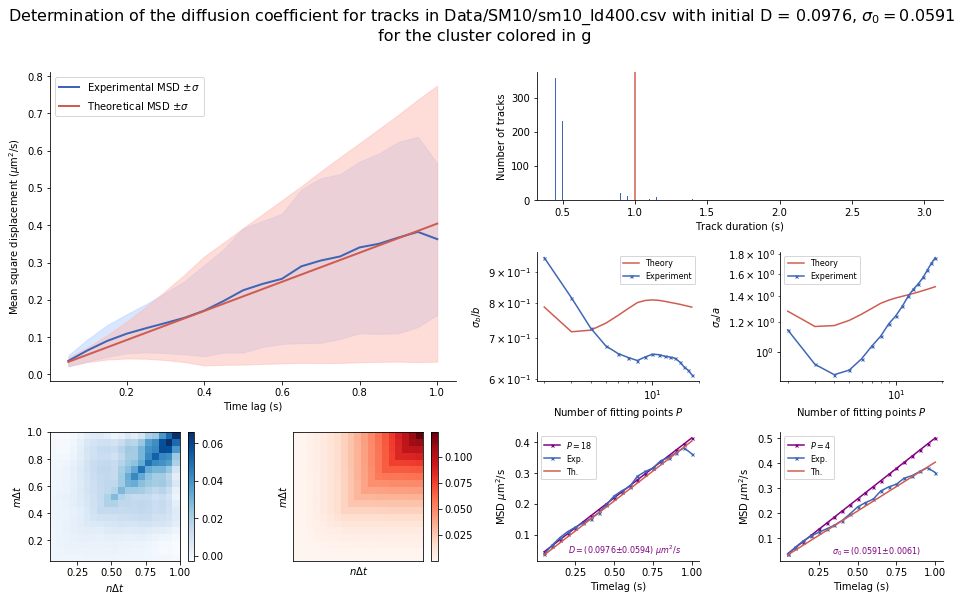

In [8]:
############## GLOBAL PLOT ###################################"

fig = plt.figure(figsize=(16, 9))
grid = plt.GridSpec(3, 4, hspace=0.4, wspace=0.5)
msd_plot = fig.add_subplot(grid[0:2,0:2])
cov_exp = fig.add_subplot(grid[2,0])
cov_th  = fig.add_subplot(grid[2,1])
hist = fig.add_subplot(grid[0,2:4])
sigmab_err = fig.add_subplot(grid[1,2])
sigmaa_err = fig.add_subplot(grid[1,3])
D_plot = fig.add_subplot(grid[2,2])
loc_unc_plot = fig.add_subplot(grid[2,3])

cexp = "#3e66b5"
cth  = "#cf5c50"
msize = 3.0

######## MSD SUBPLOT #######################
msd_plot.spines["top"].set_visible(False)  
msd_plot.spines["right"].set_visible(False)
msd_plot.get_xaxis().tick_bottom()  
msd_plot.get_yaxis().tick_left()
msd_plot.fill_between(timelag,[a - np.sqrt(b) for a,b in zip(msd,var)],[a + np.sqrt(b) for a,b in zip(msd,var)], color="#b3d1ff",alpha=0.5)
msd_plot.fill_between(timelag,[a - np.sqrt(b) for a,b in zip(theory_msd,theory_variance)],[a + np.sqrt(b) for a,b in zip(theory_msd,theory_variance)], color="#febab3",alpha=0.5) 
msd_plot.plot(timelag,msd,color=cexp, lw=2,label="Experimental MSD $\pm \sigma $")
msd_plot.plot(timelag,theory_msd,color=cth, lw=2,label="Theoretical MSD $\pm \sigma $")
msd_plot.set_ylabel(r"Mean square displacement ($\mu$m$^2/$s)",fontsize=10)
msd_plot.set_xlabel('Time lag (s)',fontsize=10)
msd_plot.legend(loc="upper left",fontsize=10)

########## HISTOGRAM ########################"

hist.spines["top"].set_visible(False)  
hist.spines["right"].set_visible(False)
hist.get_xaxis().tick_bottom()  
hist.get_yaxis().tick_left()
hist_array = [n*dt for n in N_array]
hist.hist(hist_array,color=cexp, bins=int(len(N_array)))
hist.axvline(cutoff*dt, 0, max(hist_array),color=cth)
hist.set_xlabel('Track duration (s)',fontsize=10)
hist.set_ylabel('Number of tracks',fontsize=10)

######## COVARIANCE #############################

im1 = cov_exp.pcolormesh(timelag,timelag,cov,cmap="Blues")
cov_exp.set_xlabel(r'$n \Delta t$')
cov_exp.set_ylabel(r'$m \Delta t$')
cbar = plt.colorbar(im1,ax=cov_exp)
#plt.title('Map of experimental covariance values')

im2 = cov_th.pcolormesh(timelag,timelag,theory_covariance,cmap="Reds")
#cov_th.colorbar()
cov_th.set_xticks([])
cov_th.set_yticks([])
cov_th.set_xlabel(r'$n \Delta t$')
cov_th.set_ylabel(r'$m \Delta t$')
cbar = plt.colorbar(im2,ax=cov_th)
#cov_th.set_title('Map of theoretical covariance values')


############## ERRORS ###################################
sigmab_err.spines["top"].set_visible(False)  
sigmab_err.spines["right"].set_visible(False)
sigmab_err.get_xaxis().tick_bottom()  
sigmab_err.get_yaxis().tick_left()
sigmab_err.loglog(Pmin_array,sigmab_exp_th,label="Theory",color=cth)
sigmab_err.loglog(Pmin_array,sigmab_exp,"-x",label="Experiment",color=cexp,ms=msize)
sigmab_err.set_xlabel('Number of fitting points $P$')
sigmab_err.set_ylabel(r'$\sigma_b / b$')
sigmab_err.legend(fontsize=8)

sigmaa_err.spines["top"].set_visible(False)  
sigmaa_err.spines["right"].set_visible(False)
sigmaa_err.get_xaxis().tick_bottom()  
sigmaa_err.get_yaxis().tick_left()
sigmaa_err.loglog(Pmin_array,sigmaa_exp_th,label="Theory",color=cth)
#sigmaa_err.loglog(Pmin_array,sigmaa_exp_th,".",label="Control_theory from matrices")
sigmaa_err.loglog(Pmin_array,sigmaa_exp,"-x",label="Experiment",color=cexp,ms=msize)
sigmaa_err.set_xlabel('Number of fitting points $P$')
sigmaa_err.set_ylabel(r'$\sigma_a / a$')
sigmaa_err.legend(fontsize=8)

############" LINEAR FITS ######################################
D_plot.spines["top"].set_visible(False)  
D_plot.spines["right"].set_visible(False)
D_plot.get_xaxis().tick_bottom()  
D_plot.get_yaxis().tick_left()
D_plot.plot(x, fit_b,"-x",label=r'$P = $'+str(ctffb),color="purple",ms=msize)
D_plot.plot(timelag,msd,"-x",label="Exp.",color=cexp,ms=msize)
D_plot.plot(timelag,theory_msd,label="Th.",color=cth)
D_plot.legend(loc="upper left",fontsize=8)
D_plot.set_xlabel('Timelag (s)')
D_plot.set_ylabel(r'MSD $\mu$m$^2/$s')
D_plot.text(max(timelag)/5,max(msd)/10,r'$D = ($'+str(Dvalue)+"$\pm$"+str(Dvalue_error)+") $\mu m^2 / s$",color="purple",fontsize=8)

loc_unc_plot.spines["top"].set_visible(False)  
loc_unc_plot.spines["right"].set_visible(False)
loc_unc_plot.get_xaxis().tick_bottom()  
loc_unc_plot.get_yaxis().tick_left()
loc_unc_plot.plot(x, fit_a,"-x",label=r'$P = $'+str(ctffa),color="purple",ms=msize)
loc_unc_plot.plot(timelag,msd,"x-",label="Exp.",color=cexp,ms=msize)
loc_unc_plot.plot(timelag,theory_msd,label="Th.",color=cth)
loc_unc_plot.legend(loc="upper left",fontsize=8)
loc_unc_plot.set_xlabel('Timelag (s)')
loc_unc_plot.set_ylabel(r'MSD $\mu$m$^2/$s')
loc_unc_plot.text(max(timelag)/3,max(msd)/10,r'$\sigma_0 = ($'+str(loc_sigma)+"$\pm$"+str(loc_sigma_error)+")",color="purple",fontsize=8)

fig.suptitle(r'Determination of the diffusion coefficient for tracks in '+filename+" with initial D = "+str(D)+", $\sigma_0 = $"+str(sigma)+"\n for the cluster colored in "+clustercolor, fontsize=16)
#plt.savefig(output_folder+'/graphs.png')
plt.show()